Investigates the use of batch normalization for model fitting

In [1]:
%load_ext autoreload
%autoreload 1

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import torch

from janelia_core.ml.extra_torch_modules import DenseLNLNet

In [3]:
%matplotlib notebook

## Parameters go here

In [4]:
# X Dimension 
x_d = 100

# Number of samples we generate
n_smps = 10000

# Noise standard deviation on 1
y_std = 1

## Define true model

In [5]:
def nl_transform(l: torch.Tensor):
    """ Applies the non-linear transformation x + sin(3*x) element-wise. 
        
        Args:
            l: data to transform, of any shape.
            
        Returns: 
        
            z: Transformed data
        
    """
    return l + torch.sin(3*l)

In [6]:
class TrueMdl(torch.nn.Module):
    """ Defines the true model we will generate data from and seek to recover."""
    
    def __init__(self, x_d: int, noise_std: float):
        """ Creates a new true model. 
        
        The form of the model is y_i = f(l_i) + ep_i, where:
        
            f(l_i) = l_i + sin(3*l_i)
            l_i = w'*x_i, for a weight vector w. 
            ep_i ~ N(0, noise_std^2).
        
        Args:
            x_d: The dimension of input
            
            noise_std: The standard deviation of the noise added iid to y.
        """
        super().__init__()
        self.w = torch.nn.Parameter(torch.zeros(x_d))
        # Initialize w randomly
        torch.nn.init.normal_(self.w, 0, .1) 
        
        self.noise_std = noise_std
        
    def project(self, x: torch.Tensor):
        """ Only projects input down to the low-d space, but does not pass it through the non-linearity.
        
        Args:
        
            x: input of shapd n_smps*d_x
            
        Returns: 
        
            l: projected data, a vector of length l
        
        """
        
        return torch.sum(x*self.w, dim=1)
        
            
    def forward(self, x: torch.Tensor):
        """ Computes noiseless output. 
        
        Args:
        
            x: Input of shape n_smps * d_x
        """
        return nl_transform(self.project(x))
    
    def sample(self, x: torch.Tensor):
        """ Returns samples from the model. 
        
        Args:
        
            x: Input, of shape n_smps*x_d
            
        Returns: 

            mn: The output of the model before noise is added

            y: The output of the model after noise is added 
        """
        mn = self.forward(x)
        noise = self.noise_std*torch.randn(x.shape[0])
        y = mn + noise
        
        return (mn, y)

## Define the model we will fit 

In [7]:
class EstMdl(torch.nn.Module):
    """ Defines the form of the model we estimate. """
    
    def __init__(self, x_d: int, init_noise_std: float, m: torch.nn.Module):
        """ Creates a new EstMdl object. 
        
        Args:
            x_d: The dimensionality of the input
            
            init_noise_std: The initial value of the noise standard deviation
            
            m: A torch module we will fit to learn the non-linear transformation 
        """
        super().__init__()
        self.w = torch.nn.Parameter(torch.zeros(x_d))
        torch.nn.init.normal_(self.w, 0, .001)
        
        self.noise_std = torch.nn.Parameter(torch.Tensor([init_noise_std]))
        
        self.m = m
    
    def project(self, x: torch.Tensor):
        """ Only projects input down to the low-d space, but does not pass it through the non-linearity.
        
        Args:
        
            x: input of shapd n_smps*d_x
            
        Returns: 
        
            l: projected data, a vector of length l
        
        """
        
        return torch.sum(x*self.w, dim=1)
       
    
    def forward(self, x):
        """Computes expected output of model given input
        
            Formally, "expected output" is the mean of y|x. 
            
        Args: 
            x: Input of shape n_smps*x_d
            
        Returns:
            y: expected output of length n_smps
        """
        
        return self.m(torch.sum(x*self.w, dim=1, keepdim=True)).squeeze()
    
    def ll(self, y, y_hat):
        """ Computes the log-likelihood of observed y, given the expected y from a model."""
        n_smps = len(y)
        dist_sum = -1*torch.sum((1/self.noise_std**2)*((y - y_hat)**2))
        constant = -.5*n_smps*torch.log(2*torch.tensor(np.pi)*(self.noise_std**2))
        return dist_sum + constant
    

### Define a module with the true non-linear function, for testing purposes 

In [8]:
class TrueM(torch.nn.Module):
    
    def __init(self):
        super().__init__()
            
    def forward(self, x):
        return nl_transform(x)

## Generate data from the true model 

In [9]:
true_mdl = TrueMdl(x_d=x_d, noise_std=y_std)
with torch.no_grad():
    x = torch.randn([n_smps, x_d])
    y_clean, y = true_mdl.sample(x)

## Fit a model to the data 

In [10]:
# Define the neural network we will use to learn the non-learn transformation function 

# Number of layers and growth rate go here
n_layers = 2
growth_rate = 40

# Calculat out dimension of dense net
dn_out = 1 + n_layers*growth_rate

### Initialize the model we will fit 

In [11]:
m = torch.nn.Sequential(DenseLNLNet(nl_class=torch.nn.ReLU, d_in=1, n_layers=2, growth_rate=40, bias=True),
                        torch.nn.Linear(in_features=dn_out, out_features=1, bias=True))

In [12]:
est_mdl = EstMdl(x_d=x_d, init_noise_std=y_std, m=m)

### Fit the model 

In [13]:
params = est_mdl.parameters()
optimizer = torch.optim.Adam(params=params, lr=.01)

In [14]:
for i in range(5000):
    optimizer.zero_grad()
    y_hat = est_mdl(x=x)
    nll = -1*est_mdl.ll(y=y, y_hat=y_hat)
    nll.backward()
    optimizer.step()
    
    if i % 100 == 0:
        print('It ' + str(i) + ' objective: ' + str(nll.item()))

It 0 objective: 34397.31640625
It 100 objective: 17636.71484375
It 200 objective: 17565.603515625
It 300 objective: 17564.876953125
It 400 objective: 17564.998046875
It 500 objective: 17566.576171875
It 600 objective: 17563.81640625
It 700 objective: 17561.091796875
It 800 objective: 17560.005859375
It 900 objective: 17591.2734375
It 1000 objective: 17580.70703125
It 1100 objective: 17558.828125
It 1200 objective: 17557.3671875
It 1300 objective: 17558.869140625
It 1400 objective: 17556.41015625
It 1500 objective: 17545.890625
It 1600 objective: 17542.25
It 1700 objective: 17532.1015625
It 1800 objective: 17545.375
It 1900 objective: 17540.75
It 2000 objective: 17528.619140625
It 2100 objective: 17524.53125
It 2200 objective: 17529.83203125
It 2300 objective: 17525.35546875
It 2400 objective: 17522.568359375
It 2500 objective: 17522.7890625
It 2600 objective: 17507.671875
It 2700 objective: 17509.0078125
It 2800 objective: 17521.8046875
It 2900 objective: 17508.6015625
It 3000 objectiv

## Plot true vs estimated predictions 

<IPython.core.display.Javascript object>


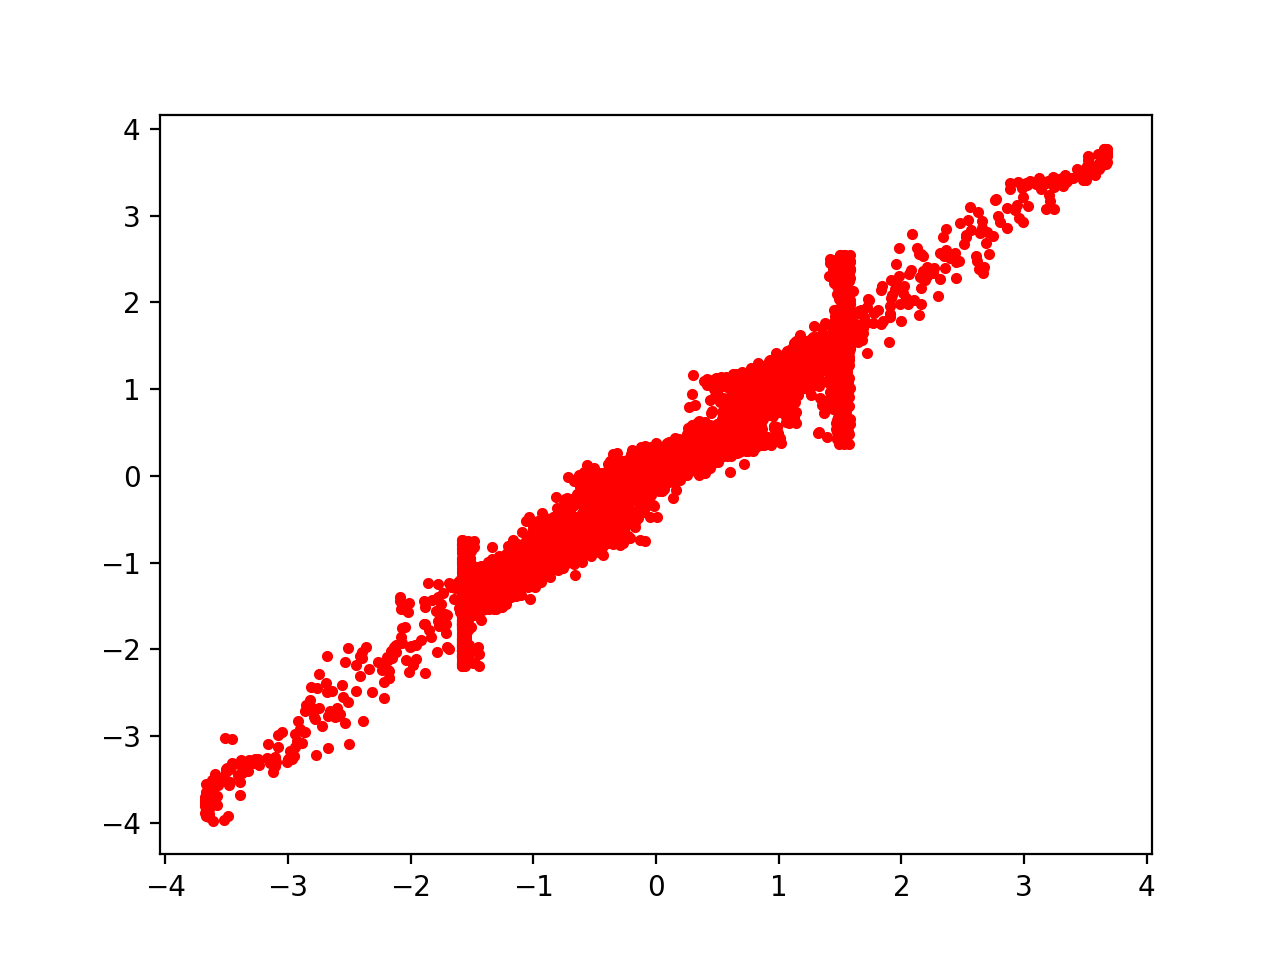

In [15]:
plt.figure()
plt.plot(y_clean.numpy(), y_hat.detach().numpy(), 'r.')

## Look at learned standard deviation

In [16]:
learned_std = est_mdl.noise_std.item()

In [17]:
learned_std

1.3823949098587036

## Look at learned non-linear function 

<IPython.core.display.Javascript object>


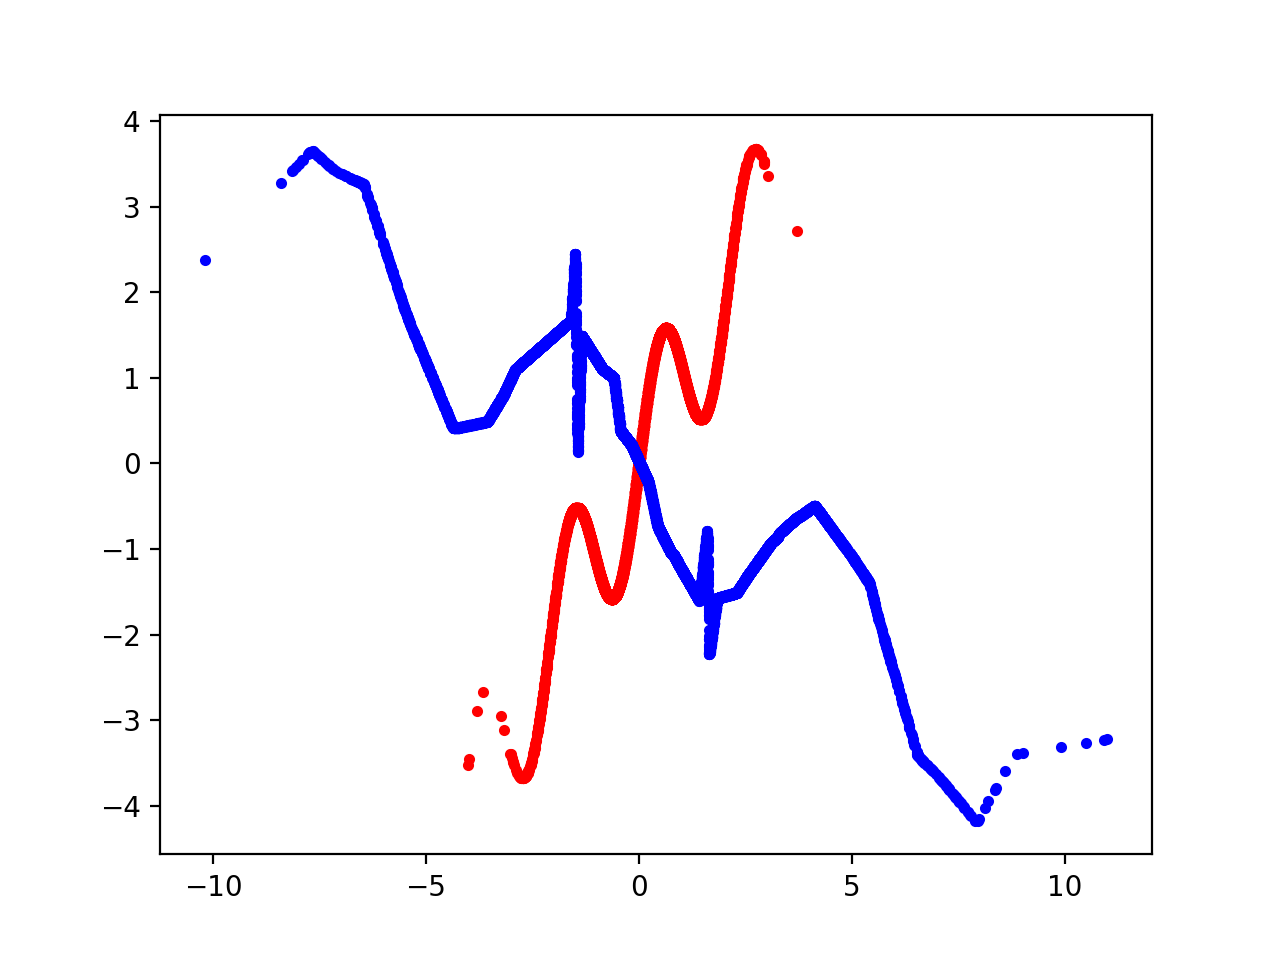

In [18]:
with torch.no_grad():
    true_l_pts = true_mdl.project(x)
    true_y_pts = true_mdl(x)
    
    est_l_pts = est_mdl.project(x)
    est_y_pts = est_mdl(x)
    
plt.figure()
plt.plot(true_l_pts, true_y_pts, 'r.')
plt.plot(est_l_pts, est_y_pts, 'b.')





# 